In [5]:
%pip install onnxruntime
%pip install insightface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


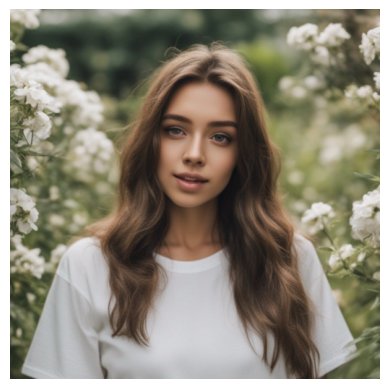

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/sagemaker-user/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/sagemaker-user/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/sagemaker-user/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/sagemaker-user/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/sagemaker-user/.insightface/models/buffalo_l/w600k_r50.onnx recognit

In [12]:
import cv2
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt
import torch

image = cv2.imread("girl.png")
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()

app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

faces = app.get(image)

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

In [2]:
import torch
from diffusers import StableDiffusionXLPipeline, DDIMScheduler
from PIL import Image

from ip_adapter.ip_adapter_faceid import IPAdapterFaceIDXL

base_model_path = "SG161222/RealVisXL_V3.0"
ip_ckpt = "ip-adapter-faceid_sdxl.bin"
device = "cuda"

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    add_watermarker=False,
)

2024-06-23 23:56:42.635641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
# load ip-adapter
ip_model = IPAdapterFaceIDXL(pipe, ip_ckpt, device)

# generate image
# prompt = "A closeup shot of a beautiful Asian teenage girl in a white dress wearing small silver earrings in the garden, under the soft morning light"
prompt="A closeup shot of super girl with cityscape in the background under the soft morning light."
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry"

images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt, faceid_embeds=faceid_embeds, num_samples=2,
    width=1024, height=1024,
    num_inference_steps=30, guidance_scale=7.5, seed=2023
)

  0%|          | 0/30 [00:00<?, ?it/s]

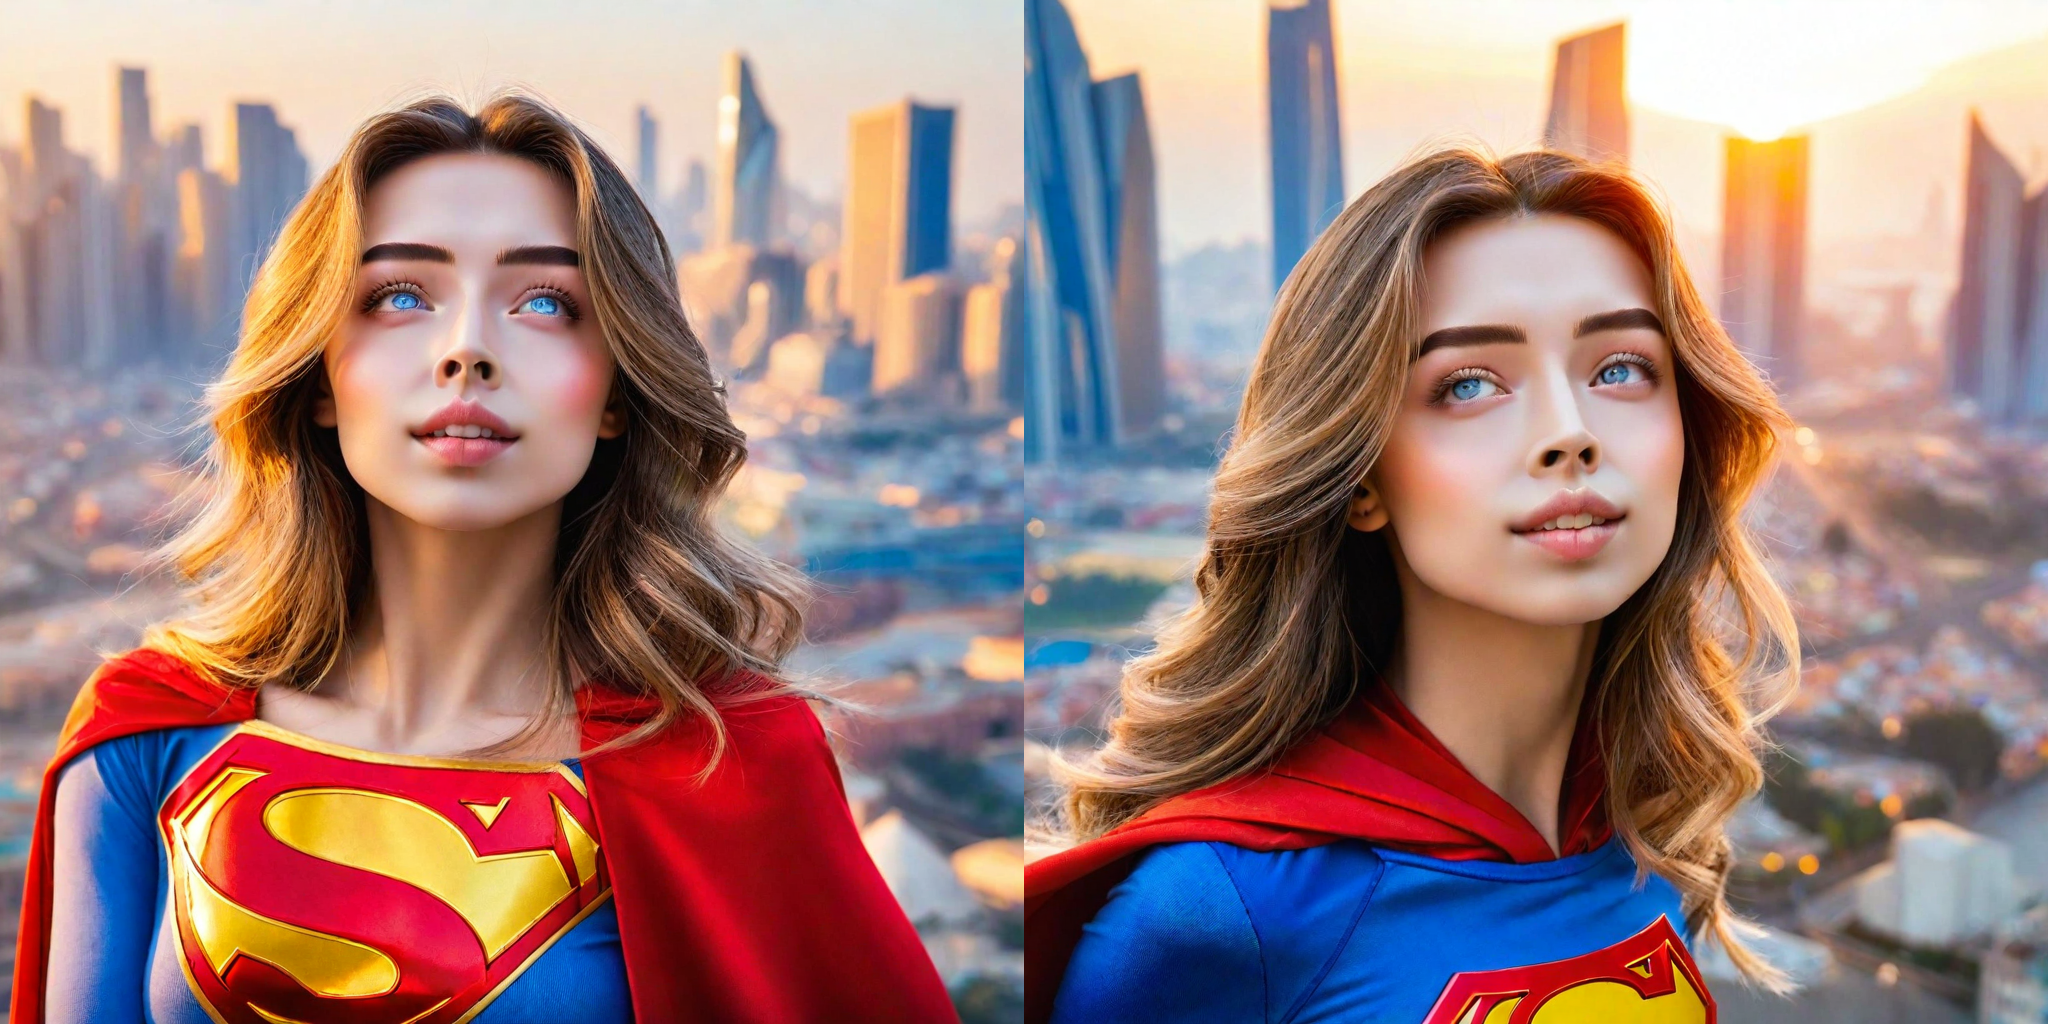

In [16]:
from diffusers.utils import load_image, make_image_grid

make_image_grid(images, rows=1, cols=2)